# Tutorial 3: Entanglement Forging Ground State Solver for the $\mathrm{H}_2\mathrm{O}$ molecule

In this tutorial, we apply Entanglement Forging to compute the energy of a $\mathrm{H}_2\mathrm{O}$ molecule. We reduce the number of orbitals in the problem, in turn reducing the number of qubits needed in each circuit. 

### Importing the relevant modules

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers import (
    GroundStateEigensolver,
    NumPyMinimumEigensolverFactory,
)

from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingAnsatz,
    EntanglementForgingGroundStateSolver,
)
from circuit_knitting_toolbox.utils import reduce_bitstrings

### Set up the $\mathrm{H}_2\mathrm{O}$ molecule, specify the driver and converter, and instantiate the `ElectronicStructureProblem`

In [2]:
radius_1 = 0.958  # position for the first H atom
radius_2 = 0.958  # position for the second H atom
thetas_in_deg = 104.478  # bond angles.

H1_x = radius_1
H2_x = radius_2 * np.cos(np.pi / 180 * thetas_in_deg)
H2_y = radius_2 * np.sin(np.pi / 180 * thetas_in_deg)

molecule = Molecule(
    geometry=[
        ["O", [0.0, 0.0, 0.0]],
        ["H", [H1_x, 0.0, 0.0]],
        ["H", [H2_x, H2_y, 0.0]],
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto6g")
problem = ElectronicStructureProblem(driver)
converter = QubitConverter(JordanWignerMapper())

### Compute the classical result

For comparison, we also compute the classical result. 

In [3]:
solver = GroundStateEigensolver(
    converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False)
)

result = solver.solve(problem)
classical_energy = result.total_energies[0]

print("Classical energy = ", classical_energy)

Classical energy =  -75.72890671869246


### Prepare the bitstrings and the ansatz

The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized circuit. For this demo, we will use the same bitstrings and ansatz for both the U and V subsystems. 

In [4]:
theta = Parameter("θ")

hop_gate = QuantumCircuit(2, name="Hop gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

hop_gate.draw()

┌───┐┌───┐     ┌────────────┐     ┌───┐
q_0: ┤ H ├┤ X ├──■──┤ Ry(-1.0*θ) ├──■──┤ H ├
     └───┘└─┬─┘┌─┴─┐├────────────┤┌─┴─┐└───┘
q_1: ───────■──┤ X ├┤ Ry(-1.0*θ) ├┤ X ├─────
               └───┘└────────────┘└───┘

In [5]:
theta_1, theta_2, theta_3, theta_4 = (
    Parameter("θ1"),
    Parameter("θ2"),
    Parameter("θ3"),
    Parameter("θ4"),
)

circuit_u = QuantumCircuit(5)
circuit_u.append(hop_gate.to_gate({theta: theta_1}), [0, 1])
circuit_u.append(hop_gate.to_gate({theta: theta_2}), [3, 4])
circuit_u.append(hop_gate.to_gate({theta: 0}), [1, 4])
circuit_u.append(hop_gate.to_gate({theta: theta_3}), [0, 2])
circuit_u.append(hop_gate.to_gate({theta: theta_4}), [3, 4])

# Set our bitstrings, and then reduce the chosen orbitals
orbitals_to_reduce = [0, 3]
bitstrings_u = [(1, 1, 1, 1, 1, 0, 0), (1, 0, 1, 1, 1, 0, 1), (1, 0, 1, 1, 1, 1, 0)]
reduced_bitstrings = reduce_bitstrings(bitstrings_u, orbitals_to_reduce)

ansatz = EntanglementForgingAnsatz(circuit_u=circuit_u, bitstrings_u=reduced_bitstrings)

ansatz.circuit_u.draw()

┌───────────────┐                ┌───────────────┐
q_0: ┤0              ├────────────────┤0              ├
     │  Hop gate(θ1) │┌──────────────┐│               │
q_1: ┤1              ├┤0             ├┤  Hop gate(θ3) ├
     └───────────────┘│              ││               │
q_2: ─────────────────┤              ├┤1              ├
     ┌───────────────┐│  Hop gate(0) │├───────────────┤
q_3: ┤0              ├┤              ├┤0              ├
     │  Hop gate(θ2) ││              ││  Hop gate(θ4) │
q_4: ┤1              ├┤1             ├┤1              ├
     └───────────────┘└──────────────┘└───────────────┘

### Set up `EntanglementForgingGroundStateSolver`

In [6]:
optimizer = COBYLA(maxiter=100)

solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=[0, 0, 0, 0],
    orbitals_to_reduce=orbitals_to_reduce,
)

### Run the solver to find the minimum eigenvalue

In [7]:
results = solver.solve(problem)

### Apply the energy shift and compare the estimated ground state energy with the classically calculated value

In [8]:
print(f"Classically calculated ground state energy: {classical_energy}")
print(
    f"Entanglement forging ground state energy: {results.groundenergy + results.energy_shift}"
)

Classically calculated ground state energy: -75.72890671869246
Entanglement forging ground state energy: -75.7048949406862


### We can also extract the results at each iteration of the classical optimizer.  

Energy:


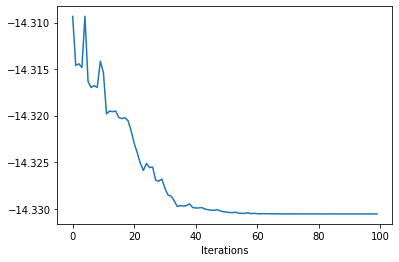

Schmidt Coefficients:


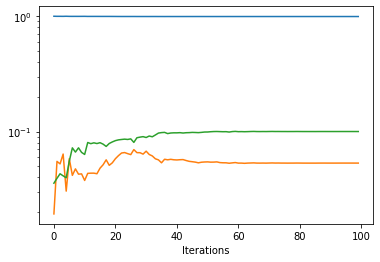

Parameters:


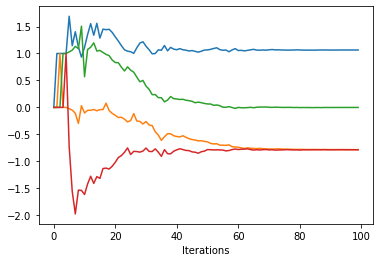

In [9]:
print("Energy:")  # prints the unshifted energy
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [10]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright